In [31]:
import face_recognition
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# import libaries

from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
import random
import sys
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchinfo import summary
from torchvision import transforms
from torch import optim
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Linear, Conv2d, BatchNorm1d, BatchNorm2d, PReLU, ReLU, ReLU6, Sigmoid, Dropout2d, Dropout, AvgPool2d, MaxPool2d, AdaptiveAvgPool2d, Sequential, Module, Parameter
from statistics import mean

import datetime
import os

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import confusion_matrix
from mtcnn import MTCNN
import cv2
 


In [32]:
print('Python version:', sys.version)
print('CUDA Available:', torch.cuda.is_available())

if torch.cuda.is_available():
    print('GPU Name:', torch.cuda.get_device_name())
    print('GPU Properties:\n', torch.cuda.get_device_properties('cuda'))
    device = "cuda"
    torch.cuda.set_per_process_memory_fraction(0.95, 0)
    torch.cuda.empty_cache()
else:
    print("Cuda is not available, please use cpu instead")
    device = "cpu"
!nvidia-smi

Python version: 3.9.0 (tags/v3.9.0:9cf6752, Oct  5 2020, 15:34:40) [MSC v.1927 64 bit (AMD64)]
CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070
GPU Properties:
 _CudaDeviceProperties(name='NVIDIA GeForce RTX 2070', major=7, minor=5, total_memory=8191MB, multi_processor_count=36)
Mon Apr 24 17:16:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 526.98       Driver Version: 526.98       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   47C    P8    26W / 175W |   1773Mi

In [33]:
seed = 41
img_size = 112

In [34]:
def face_reg(path: str):
    try:
        image = face_recognition.load_image_file(path)
        face_locations = face_recognition.face_locations(image)

        # print("I found {} face(s) in this photograph.".format(len(face_locations)))

        for face_location in face_locations:

            # Print the location of each face in this image
            top, right, bottom, left = face_location
            if top - bottom < 224:
                print('x')

            # You can access the actual face itself like this:
            face_image = image[top:bottom, left:right]
            pil_image = Image.fromarray(face_image)
            plt.imshow(pil_image)
            # print(pil_image)
        return (True, pil_image)
    except:
        print(False, None)



In [35]:
raw_ds_df = pd.read_csv('./csv_files/custom_ds.csv')

In [36]:
raw_ds_df

,identity,sub_identity,path
0,Aut,picture,./crop_face_ds\Aut\picture\frame170_83.jpg
1,Aut,picture,./crop_face_ds\Aut\picture\frame176_89.jpg
2,Aut,picture,./crop_face_ds\Aut\picture\frame228_154.jpg
3,Aut,picture,./crop_face_ds\Aut\picture\frame235_163.jpg
4,Aut,picture,./crop_face_ds\Aut\picture\frame285_224.jpg
...,...,...,...
4301,Yut,video,./crop_face_ds\Yut\video\frame276_280.jpg
4302,Yut,video,./crop_face_ds\Yut\video\frame277_281.jpg
4303,Yut,video,./crop_face_ds\Yut\video\frame278_282.jpg
4304,Yut,video,./crop_face_ds\Yut\video\frame279_283.jpg


In [37]:
# ds_df = pd.read_csv('./csv_files/vgg_face.csv')
raw_ds_df = pd.read_csv('./csv_files/custom_ds.csv')
# ds_df = pd.read_csv('./digiface_csv_files/digi_all.csv')
# ds_df = pd.read_csv('./csv_files/lfw_ds.csv')
ds_df = raw_ds_df.groupby(['identity', 'sub_identity'])['path'].apply(list).reset_index()
ds_df

,identity,sub_identity,path
0,Aut,picture,"[./crop_face_ds\Aut\picture\frame170_83.jpg, ...."
1,Aut,video,"[./crop_face_ds\Aut\video\frame0_1.jpg, ./crop..."
2,Bed,picture,"[./crop_face_ds\Bed\picture\IMG_1494_1.jpg, ./..."
3,Bed,video,"[./crop_face_ds\Bed\video\frame0_1.jpg, ./crop..."
4,Boss,picture,"[./crop_face_ds\Boss\picture\IMG_1337_1.jpg, ...."
5,Boss,video,"[./crop_face_ds\Boss\video\frame0_1.jpg, ./cro..."
6,Fon,picture,"[./crop_face_ds\Fon\picture\IMG_1351_1.jpg, ./..."
7,Fon,video,"[./crop_face_ds\Fon\video\frame0_1.jpg, ./crop..."
8,Ice,picture,"[./crop_face_ds\Ice\picture\IMG_8474_1.jpg, ./..."
9,Ice,video,"[./crop_face_ds\Ice\video\frame0_1.jpg, ./crop..."


In [38]:
ds_df[10:20]

,identity,sub_identity,path
10,Jay,picture,"[./crop_face_ds\Jay\picture\IMG_1264_1.jpg, ./..."
11,Jay,video,"[./crop_face_ds\Jay\video\frame0_1.jpg, ./crop..."
12,JoePS,picture,"[./crop_face_ds\JoePS\picture\IMG_8419_1.jpg, ..."
13,JoePS,video,"[./crop_face_ds\JoePS\video\frame0_1.jpg, ./cr..."
14,Mark,picture,"[./crop_face_ds\Mark\picture\IMG_1407_1.jpg, ...."
15,Mark,video,"[./crop_face_ds\Mark\video\frame0_1.jpg, ./cro..."
16,Mine,picture,"[./crop_face_ds\Mine\picture\IMG_1173_1.jpg, ...."
17,Mine,video,"[./crop_face_ds\Mine\video\frame0_1.jpg, ./cro..."
18,Ong,picture,"[./crop_face_ds\Ong\picture\IMG_1323_1.jpg, ./..."
19,Ong,video,"[./crop_face_ds\Ong\video\frame0_1.jpg, ./crop..."


In [39]:
name_more = list()
# more than 2 videos 
for name in list(ds_df['identity'].unique()):
    if ds_df[ds_df['identity'] == name].shape[0] >= 2: 
        name_more.append(name)

In [40]:
# ds_df[ds_df['identity'].isin(name_more)]

anc_df = pd.DataFrame()
# append all identity 
for identity in name_more: 
    temp_anc = ds_df[(ds_df['identity'] == identity) & (ds_df['sub_identity'] == 'picture')].reset_index().T.pop(0)
    anc_df = pd.concat([anc_df, pd.DataFrame(temp_anc).T], axis = 0)

In [41]:
anc_df= anc_df.set_index('index')

In [42]:
anc_df

,identity,sub_identity,path
index,,,
0,Aut,picture,"[./crop_face_ds\Aut\picture\frame170_83.jpg, ...."
2,Bed,picture,"[./crop_face_ds\Bed\picture\IMG_1494_1.jpg, ./..."
4,Boss,picture,"[./crop_face_ds\Boss\picture\IMG_1337_1.jpg, ...."
6,Fon,picture,"[./crop_face_ds\Fon\picture\IMG_1351_1.jpg, ./..."
8,Ice,picture,"[./crop_face_ds\Ice\picture\IMG_8474_1.jpg, ./..."
10,Jay,picture,"[./crop_face_ds\Jay\picture\IMG_1264_1.jpg, ./..."
12,JoePS,picture,"[./crop_face_ds\JoePS\picture\IMG_8419_1.jpg, ..."
14,Mark,picture,"[./crop_face_ds\Mark\picture\IMG_1407_1.jpg, ...."
16,Mine,picture,"[./crop_face_ds\Mine\picture\IMG_1173_1.jpg, ...."


In [43]:
# remove less than 2 identity
test_df = ds_df[ds_df['identity'].isin(list(anc_df['identity']))]
test_df

,identity,sub_identity,path
0,Aut,picture,"[./crop_face_ds\Aut\picture\frame170_83.jpg, ...."
1,Aut,video,"[./crop_face_ds\Aut\video\frame0_1.jpg, ./crop..."
2,Bed,picture,"[./crop_face_ds\Bed\picture\IMG_1494_1.jpg, ./..."
3,Bed,video,"[./crop_face_ds\Bed\video\frame0_1.jpg, ./crop..."
4,Boss,picture,"[./crop_face_ds\Boss\picture\IMG_1337_1.jpg, ...."
5,Boss,video,"[./crop_face_ds\Boss\video\frame0_1.jpg, ./cro..."
6,Fon,picture,"[./crop_face_ds\Fon\picture\IMG_1351_1.jpg, ./..."
7,Fon,video,"[./crop_face_ds\Fon\video\frame0_1.jpg, ./crop..."
8,Ice,picture,"[./crop_face_ds\Ice\picture\IMG_8474_1.jpg, ./..."
9,Ice,video,"[./crop_face_ds\Ice\video\frame0_1.jpg, ./crop..."


In [44]:
# remove the anchor identity and sub_identity
test_df = pd.concat([test_df[['identity','sub_identity']],anc_df[['identity','sub_identity']]]).drop_duplicates(keep=False)
test_df

,identity,sub_identity
1,Aut,video
3,Bed,video
5,Boss,video
7,Fon,video
9,Ice,video
11,Jay,video
13,JoePS,video
15,Mark,video
17,Mine,video
19,Ong,video


In [45]:
# get ungroup identity
temp_ds_df = raw_ds_df.copy()
test_df = temp_ds_df.merge(test_df, on = ['identity','sub_identity'])
display(test_df)
# test_df

,identity,sub_identity,path
0,Aut,video,./crop_face_ds\Aut\video\frame0_1.jpg
1,Aut,video,./crop_face_ds\Aut\video\frame100_4.jpg
2,Aut,video,./crop_face_ds\Aut\video\frame101_5.jpg
3,Aut,video,./crop_face_ds\Aut\video\frame102_6.jpg
4,Aut,video,./crop_face_ds\Aut\video\frame103_7.jpg
...,...,...,...
4037,Yut,video,./crop_face_ds\Yut\video\frame276_280.jpg
4038,Yut,video,./crop_face_ds\Yut\video\frame277_281.jpg
4039,Yut,video,./crop_face_ds\Yut\video\frame278_282.jpg
4040,Yut,video,./crop_face_ds\Yut\video\frame279_283.jpg


In [46]:
test_df = test_df.groupby(['identity'])['path'].apply(list).reset_index()
test_df

,identity,path
0,Aut,"[./crop_face_ds\Aut\video\frame0_1.jpg, ./crop..."
1,Bed,"[./crop_face_ds\Bed\video\frame0_1.jpg, ./crop..."
2,Boss,"[./crop_face_ds\Boss\video\frame0_1.jpg, ./cro..."
3,Fon,"[./crop_face_ds\Fon\video\frame0_1.jpg, ./crop..."
4,Ice,"[./crop_face_ds\Ice\video\frame0_1.jpg, ./crop..."
5,Jay,"[./crop_face_ds\Jay\video\frame0_1.jpg, ./crop..."
6,JoePS,"[./crop_face_ds\JoePS\video\frame0_1.jpg, ./cr..."
7,Mark,"[./crop_face_ds\Mark\video\frame0_1.jpg, ./cro..."
8,Mine,"[./crop_face_ds\Mine\video\frame0_1.jpg, ./cro..."
9,Ong,"[./crop_face_ds\Ong\video\frame0_1.jpg, ./crop..."


In [47]:
check = list()
for inx, each in enumerate(list(test_df['identity'])):
    if list(anc_df['identity'])[inx] == each: 
        check.append(True)
    else: 
        check.append(False)
pd.Series(check).value_counts()

True    22
dtype: int64

In [48]:
class Flatten(Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


def l2_norm(input, axis = 1):
    norm = torch.norm(input, 2, axis, True)
    output = torch.div(input, norm)
    return output


class h_sigmoid(Module):
    def __init__(self, inplace = True):
        super(h_sigmoid, self).__init__()
        self.relu = ReLU6(inplace = inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(Module):
    def __init__(self, inplace = True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace = inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(Module):
    def __init__(self, channel, reduction = 4):
        super(SELayer, self).__init__()
        self.avg_pool = AdaptiveAvgPool2d(1)
        self.fc = Sequential(Linear(channel, channel // reduction), ReLU(inplace = True),
                             Linear(channel // reduction, channel), h_sigmoid())

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


class PermutationBlock(Module):
    def __init__(self, groups):
        super(PermutationBlock, self).__init__()
        self.groups = groups

    def forward(self, input):
        n, c, h, w = input.size()
        G = self.groups
        output = input.view(n, G, c // G, h, w).permute(0, 2, 1, 3, 4).contiguous().view(n, c, h, w)
        return output


class Conv_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Conv_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)
        self.prelu = PReLU(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.prelu(x)
        return x


class Linear_block(Module):
    def __init__(self, in_c, out_c, kernel = (1, 1), stride = (1, 1), padding = (0, 0), groups = 1):
        super(Linear_block, self).__init__()
        self.conv = Conv2d(in_c, out_channels = out_c, kernel_size = kernel, groups = groups, stride = stride,
                           padding = padding, bias = False)
        self.bn = BatchNorm2d(out_c)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return x


class Depth_Wise(Module):
    def __init__(self, in_c, out_c, residual = False, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 1):
        super(Depth_Wise, self).__init__()
        self.conv = Conv_block(in_c, out_c = groups, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.conv_dw = Conv_block(groups, groups, groups = groups, kernel = kernel, padding = padding, stride = stride)
        self.project = Linear_block(groups, out_c, kernel = (1, 1), padding = (0, 0), stride = (1, 1))
        self.residual = residual

    def forward(self, x):
        if self.residual:
            short_cut = x
        x = self.conv(x)
        x = self.conv_dw(x)
        x = self.project(x)
        if self.residual:
            output = short_cut + x
        else:
            output = x
        return output


class Residual(Module):
    def __init__(self, c, num_block, groups, kernel = (3, 3), stride = (1, 1), padding = (1, 1)):
        super(Residual, self).__init__()
        modules = []
        for _ in range(num_block):
            modules.append(
                Depth_Wise(c, c, residual = True, kernel = kernel, padding = padding, stride = stride, groups = groups))
        self.model = Sequential(*modules)

    def forward(self, x):
        return self.model(x)


class LinearScheduler(nn.Module):
    def __init__(self, dropblock, start_value, stop_value, nr_steps):
        super(LinearScheduler, self).__init__()
        self.dropblock = dropblock
        self.i = 0
        self.drop_values = np.linspace(start = start_value, stop = stop_value, num = nr_steps)

    def forward(self, x):
        return self.dropblock(x)

    def step(self):
        if self.i < len(self.drop_values):
            self.dropblock.drop_prob = self.drop_values[self.i]

        self.i += 1


class DropBlock2D(nn.Module):

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input = mask[:, None, :, :], kernel_size = (
            self.block_size, self.block_size), stride = (1, 1), padding = self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)

class MobileFaceNet(Module):
    def __init__(self, embedding_size = 512):
        super(MobileFaceNet, self).__init__()
        self.conv1 = Conv_block(3, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1))
        self.conv2_dw = Conv_block(64, 64, kernel = (3, 3), stride = (1, 1), padding = (1, 1), groups = 64)
        self.conv_23 = Depth_Wise(64, 64, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 128)
        self.conv_3 = Residual(64, num_block = 4, groups = 128, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_34 = Depth_Wise(64, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 256)
        self.conv_4 = Residual(128, num_block = 6, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_45 = Depth_Wise(128, 128, kernel = (3, 3), stride = (2, 2), padding = (1, 1), groups = 512)
        self.conv_5 = Residual(128, num_block = 2, groups = 256, kernel = (3, 3), stride = (1, 1), padding = (1, 1))
        self.conv_6_sep = Conv_block(128, 512, kernel = (1, 1), stride = (1, 1), padding = (0, 0))
        self.conv_6_dw = Linear_block(512, 512, groups = 512, kernel = (7, 7), stride = (1, 1), padding = (0, 0))
        self.conv_6_flatten = Flatten()
        self.linear = Linear(512, embedding_size, bias = False)
        self.bn = BatchNorm1d(embedding_size)
        self.dropblock = DropBlock2D(block_size = 3, drop_prob = 0.25)
        self.dropout = Dropout(0.25)

    def forward_once(self, x):
        out = self.conv1(x)

        out = self.conv2_dw(out)

        out = self.conv_23(out)

        out = self.conv_3(out)

        out = self.conv_34(out)
        
        out = self.dropblock(out)

        out = self.conv_4(out)
        
        out = self.dropout(out)

        out = self.conv_45(out)
        
        out = self.dropblock(out)
        
        out = self.conv_5(out)

        out = self.conv_6_sep(out)

        out = self.dropblock(out)

        out = self.conv_6_dw(out)

        out = self.dropblock(out)

        out = self.conv_6_flatten(out)

        out = self.linear(out)

        out = self.bn(out)

        return l2_norm(out)

    def forward(self, img):
        anchor = self.forward_once(img)
        return anchor



In [49]:
triplet_model = MobileFaceNet()
print(summary(triplet_model, input_size = [(32, 3, 112, 112)]))

Layer (type:depth-idx)                        Output Shape              Param #
MobileFaceNet                                 [32, 512]                 --
├─Conv_block: 1-1                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-1                            [32, 64, 56, 56]          1,728
│    └─BatchNorm2d: 2-2                       [32, 64, 56, 56]          128
│    └─PReLU: 2-3                             [32, 64, 56, 56]          64
├─Conv_block: 1-2                             [32, 64, 56, 56]          --
│    └─Conv2d: 2-4                            [32, 64, 56, 56]          576
│    └─BatchNorm2d: 2-5                       [32, 64, 56, 56]          128
│    └─PReLU: 2-6                             [32, 64, 56, 56]          64
├─Depth_Wise: 1-3                             [32, 64, 28, 28]          --
│    └─Conv_block: 2-7                        [32, 128, 56, 56]         --
│    │    └─Conv2d: 3-1                       [32, 128, 56, 56]         8,192
│    │    └

In [50]:
def open_img(img_path): 
    img = Image.open(img_path).convert('YCbCr')
    img = test_transform(img).unsqueeze(0)
    return img
test_transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5, 0.5, 0.5],
                        std = [0.5, 0.5, 0.5])
    ])
distance = list()
distance2 = list()
anc_id = list()
test_id = list()

anc_path = list()
test_path = list()

anc_img_no = list()
test_img_no = list()

latest_weight_path ='./weights/mobile_network_120_updated20230415 100317.pth'
latest_weight_path2 ='./weights/mobile_network_120_updated20230417 125226.pth'

latest_weight_path_temp = './weights/mobile_network_120_updated20230422 201552.pth'

np.random.seed(42)
# model = MobileFaceNet().to(device)
# model.load_state_dict(torch.load(latest_weight_path))
# model.eval()

model2 = MobileFaceNet().to(device)
model2.load_state_dict(torch.load(latest_weight_path_temp))
model2.eval()

with torch.no_grad():
    for anch_name in tqdm(anc_df['identity']):
        anc_list = anc_df[anc_df['identity'] == anch_name].path.values[0]
    #     print(np.random.choice(anc_list))
        anc_img_path = np.random.choice(anc_list, 3)
#         anc_img_path = anc_list[3]
        for index_anc, anc_name in enumerate(anc_img_path):
            anc_img = open_img(anc_name).to(device)
#             anc_out = model(anc_img)
            anc_out2 = model2(anc_img)
            anc_img_name = anc_name.split('\\')[-1]
#         print(anc_img_path)
            for index, test_name in enumerate(test_df['identity']):
                path = test_df[test_df['identity'] == test_name]['path'].values[0]
                for indx, each_path in enumerate(path):
    #                 print(each_path)
                    test_img = open_img(each_path).to(device)
#                     test_out = model(test_img)
                    test_out2 = model2(test_img)

#                     distance.append((anc_out - test_out).pow(2).sum(1).cpu().data.numpy()[0])
                    distance2.append((anc_out2 - test_out2).pow(2).sum(1).cpu().data.numpy()[0])

                    anc_id.append(anch_name)
                    test_id.append(test_name)

                    anc_path.append(anc_name)
                    test_path.append(each_path)

                    anc_img_no.append(anc_img_name)
                    test_img_no.append(test_name.split('\\')[-1])
        print('Done', anch_name)

  0%|          | 0/22 [00:00<?, ?it/s]

Done Aut
Done Bed
Done Boss
Done Fon
Done Ice
Done Jay
Done JoePS
Done Mark
Done Mine
Done Ong
Done Paeng
Done Pim
Done Pin
Done Pond
Done Pooh
Done Punch
Done Punnatt
Done Pyne
Done Team
Done Time
Done Tle
Done Yut


In [21]:
# latest_weight_path_temp = './weights/mobile_network_120_updated20230418 232416.pth'

# np.random.seed(42)
# # model = MobileFaceNet().to(device)
# # model.load_state_dict(torch.load(latest_weight_path))
# # model.eval()

# model2 = MobileFaceNet().to(device)
# model2.load_state_dict(torch.load(latest_weight_path_temp))
# model2.eval()

# with torch.no_grad():
#     anc_img = open_img('./crop_face_ds\\Aut\\video\\frame17.jpg').to(device)
#     anc_out2 = model2(anc_img)
    
#     pos = open_img('./crop_face_ds\\Aut\\video\\frame18.jpg').to(device)
#     pos_out = model2(pos)
#     print((anc_out2 - pos_out).pow(2).sum(1).cpu().data.numpy()[0])
    
            

FileNotFoundError: [Errno 2] No such file or directory: './crop_face_ds\\Aut\\video\\frame17.jpg'

In [51]:
result = pd.DataFrame({
#     'distance':  distance,
    'distance2': distance2,
    'anc_id':  anc_id,
    'test_id':test_id ,
    'anc_path': anc_path ,
     'test_path':test_path})

In [65]:
result = save_result.copy()

In [52]:
result['labels'] = result['anc_id'] == result['test_id']
# result['norm'] = 1/ (1+result['distance']) >= 0.6
# result['predicts'] = result['distance'] <= 0.98

result['norm2'] = 1/ (1+result['distance2']) >= 0.6
result['predicts2'] = result['distance2'] <= 0.98

# result['ensemble_norm'] = result['norm'] & result['norm2']
# result['ensemble_pred'] = result['predicts'] & result['predicts2']

result

,distance2,anc_id,test_id,anc_path,test_path,labels,norm2,predicts2
0,1.225095,Aut,Aut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Aut\video\frame0_1.jpg,True,False,False
1,1.890788,Aut,Aut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Aut\video\frame100_4.jpg,True,False,False
2,1.700403,Aut,Aut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Aut\video\frame101_5.jpg,True,False,False
3,1.650304,Aut,Aut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Aut\video\frame102_6.jpg,True,False,False
4,2.096102,Aut,Aut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Aut\video\frame103_7.jpg,True,False,False
...,...,...,...,...,...,...,...,...
266767,0.540245,Yut,Yut,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Yut\video\frame276_280.jpg,True,True,True
266768,0.592590,Yut,Yut,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Yut\video\frame277_281.jpg,True,True,True
266769,0.416409,Yut,Yut,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Yut\video\frame278_282.jpg,True,True,True
266770,0.734960,Yut,Yut,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Yut\video\frame279_283.jpg,True,False,True


In [53]:
save_result = result.copy()

In [54]:
result['labels'] = result['labels'].astype(str)
# result['predicts'] = result['predicts'].astype(str)
# result['norm'] = result['norm'].astype(str)

result['predicts2'] = result['predicts2'].astype(str)
result['norm2'] = result['norm2'].astype(str)

# result['ensemble_norm'] = result['ensemble_norm'].astype(str)
# result['ensemble_pred'] = result['ensemble_pred'].astype(str)

In [55]:
result[(result['labels'] == 'False') & (result['predicts2'] == 'True')]

,distance2,anc_id,test_id,anc_path,test_path,labels,norm2,predicts2
3853,0.881732,Aut,Yut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Yut\video\frame10_4.jpg,False,False,True
3884,0.919269,Aut,Yut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Yut\video\frame138_56.jpg,False,False,True
3888,0.783558,Aut,Yut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Yut\video\frame141_60.jpg,False,False,True
3889,0.798101,Aut,Yut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Yut\video\frame142_61.jpg,False,False,True
3997,0.929794,Aut,Yut,./crop_face_ds\Aut\picture\frame235_163.jpg,./crop_face_ds\Yut\video\frame23_211.jpg,False,False,True
...,...,...,...,...,...,...,...,...
266536,0.956267,Yut,Tle,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Tle\video\frame68_94.jpg,False,False,True
266537,0.936586,Yut,Tle,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Tle\video\frame69_95.jpg,False,False,True
266539,0.970834,Yut,Tle,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Tle\video\frame70_97.jpg,False,False,True
266542,0.879074,Yut,Tle,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Tle\video\frame73_100.jpg,False,False,True


In [56]:
result[(result['labels'] == 'False') & (result['norm2'] == 'True')]

,distance2,anc_id,test_id,anc_path,test_path,labels,norm2,predicts2
12196,0.640500,Bed,Aut,./crop_face_ds\Bed\picture\IMG_1501_9.jpg,./crop_face_ds\Aut\video\frame156_65.jpg,False,True,True
12198,0.600887,Bed,Aut,./crop_face_ds\Bed\picture\IMG_1501_9.jpg,./crop_face_ds\Aut\video\frame157_66.jpg,False,True,True
12200,0.660208,Bed,Aut,./crop_face_ds\Bed\picture\IMG_1501_9.jpg,./crop_face_ds\Aut\video\frame158_67.jpg,False,True,True
12202,0.660398,Bed,Aut,./crop_face_ds\Bed\picture\IMG_1501_9.jpg,./crop_face_ds\Aut\video\frame159_68.jpg,False,True,True
12210,0.631431,Bed,Aut,./crop_face_ds\Bed\picture\IMG_1501_9.jpg,./crop_face_ds\Aut\video\frame163_73.jpg,False,True,True
...,...,...,...,...,...,...,...,...
263725,0.364925,Yut,Ice,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Ice\video\frame276_198.jpg,False,True,True
263726,0.316841,Yut,Ice,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Ice\video\frame277_199.jpg,False,True,True
263727,0.376766,Yut,Ice,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Ice\video\frame278_200.jpg,False,True,True
263728,0.315320,Yut,Ice,./crop_face_ds\Yut\picture\IMG_1371_7.jpg,./crop_face_ds\Ice\video\frame279_201.jpg,False,True,True


In [57]:
result_dict = dict()
for anc_id in result['anc_id'].unique():
    # get only the concerning identity
    filtered_res = result[result['anc_id'] == anc_id]
    # get each test_id 
    test_lst = result['test_id'].unique()
    # add each anc to dict
    if anc_id not in result_dict.keys():
        result_dict[anc_id] = dict()
    # calculate for each test id 
    for test_id in test_lst: 
        filtered_res_per_id = filtered_res[filtered_res['test_id'] == test_id]
        percentage_dict = filtered_res_per_id['norm2'].value_counts(normalize=True).to_dict()
        
        if 'False' not in percentage_dict.keys():
            percentage_dict['False'] = 0.0
        if 'True' not in percentage_dict.keys():
            percentage_dict['True'] = 0.0
        
#         result_dict[anc_id][test_id]['result'] = percentage_dict
        
        if percentage_dict['True'] >= 0.5: 
            result_dict[anc_id][test_id] = [True,percentage_dict['True'],percentage_dict['False']]
        else: 
            result_dict[anc_id][test_id] = [False,percentage_dict['True'],percentage_dict['False']]

In [58]:
result_dict

{'Aut': {'Aut': [False, 0.21666666666666667, 0.7833333333333333],
  'Bed': [False, 0.0, 1.0],
  'Boss': [False, 0.0, 1.0],
  'Fon': [False, 0.0, 1.0],
  'Ice': [False, 0.0, 1.0],
  'Jay': [False, 0.0, 1.0],
  'JoePS': [False, 0.0, 1.0],
  'Mark': [False, 0.0, 1.0],
  'Mine': [False, 0.0, 1.0],
  'Ong': [False, 0.0, 1.0],
  'Paeng': [False, 0.0, 1.0],
  'Pim': [False, 0.0, 1.0],
  'Pin': [False, 0.0, 1.0],
  'Pond': [False, 0.0, 1.0],
  'Pooh': [False, 0.0, 1.0],
  'Punch': [False, 0.0, 1.0],
  'Punnatt': [False, 0.0, 1.0],
  'Pyne': [False, 0.0, 1.0],
  'Team': [False, 0.0, 1.0],
  'Time': [False, 0.0, 1.0],
  'Tle': [False, 0.0, 1.0],
  'Yut': [False, 0.0, 1.0]},
 'Bed': {'Aut': [False, 0.013333333333333334, 0.9866666666666667],
  'Bed': [True, 0.9816666666666667, 0.018333333333333333],
  'Boss': [False, 0.0, 1.0],
  'Fon': [False, 0.0, 1.0],
  'Ice': [False, 0.0, 1.0],
  'Jay': [False, 0.0, 1.0],
  'JoePS': [False, 0.0, 1.0],
  'Mark': [False, 0.13833333333333334, 0.8616666666666667]

In [63]:
match_zip = list()
for key in result_dict.keys(): 
    for sub_key in result_dict[key].keys(): 
        validation = result_dict[key][sub_key][0]
        if validation & (key == sub_key): 
            print(f'Validation at {key} matched with {sub_key}')
        elif validation: 
            print(f'Validation at {key} had wrong matched with {sub_key} at prob {result_dict[key][sub_key][1]}')
            match_zip.append((key, sub_key))

Validation at Bed matched with Bed
Validation at Fon matched with Fon
Validation at Jay matched with Jay
Validation at Mark matched with Mark
Validation at Ong matched with Ong
Validation at Pim matched with Pim
Validation at Pin matched with Pin
Validation at Pond matched with Pond
Validation at Pooh matched with Pooh
Validation at Punch matched with Punch
Validation at Team matched with Team
Validation at Tle matched with Tle


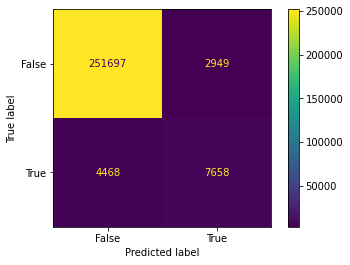

In [64]:
from sklearn import metrics
metrics.ConfusionMatrixDisplay(confusion_matrix(result['labels'], result['norm2']), display_labels = ['False', 'True']).plot()

In [65]:
match_zip

[]

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(result['norm2'], result['labels'])

0.9721972320933231

In [42]:
 result[(result['labels'] == 'False')  & (result['anc_id'] == 'Jay') | (result['anc_id'] == 'Mine')]

,distance2,anc_id,test_id,anc_path,test_path,labels,norm2,predicts2
54585,2.168381,Jay,Aut,./crop_face_ds\Jay\picture\IMG_1271_8.jpg,./crop_face_ds\Aut\video\frame0.jpg,False,False,False
54586,2.024601,Jay,Aut,./crop_face_ds\Jay\picture\IMG_1271_8.jpg,./crop_face_ds\Aut\video\frame1.jpg,False,False,False
54587,1.720412,Jay,Aut,./crop_face_ds\Jay\picture\IMG_1271_8.jpg,./crop_face_ds\Aut\video\frame10.jpg,False,False,False
54588,2.159366,Jay,Aut,./crop_face_ds\Jay\picture\IMG_1271_8.jpg,./crop_face_ds\Aut\video\frame100.jpg,False,False,False
54589,2.048810,Jay,Aut,./crop_face_ds\Jay\picture\IMG_1271_8.jpg,./crop_face_ds\Aut\video\frame101.jpg,False,False,False
...,...,...,...,...,...,...,...,...
98248,1.440846,Mine,Yut,./crop_face_ds\Mine\picture\IMG_1174.JPG,./crop_face_ds\Yut\video\frame288.jpg,False,False,False
98249,1.812693,Mine,Yut,./crop_face_ds\Mine\picture\IMG_1174.JPG,./crop_face_ds\Yut\video\frame289.jpg,False,False,False
98250,1.500169,Mine,Yut,./crop_face_ds\Mine\picture\IMG_1174.JPG,./crop_face_ds\Yut\video\frame29.jpg,False,False,False
98251,1.887487,Mine,Yut,./crop_face_ds\Mine\picture\IMG_1174.JPG,./crop_face_ds\Yut\video\frame290.jpg,False,False,False


In [62]:
false_pos_df = result[(result['labels'] == 'False') & (result['norm2'] == 'True')]
for wrong in match_zip: 
    print(wrong[0])
    for _,each_row in false_pos_df.iterrows():
    #     print(each_row['anch_imgs_name'])
        if each_row['anc_id'] == wrong[0] and each_row['test_id'] == wrong[1]:
            img1 = Image.open(each_row['anc_path']).resize((112,112))
            img2 = Image.open(each_row['test_path']).resize((112,112))
            text1 = each_row['test_path']
            concatenated = np.concatenate([img1,img2],1)
            plt.text(120, 8, 'distance:'+ str(round(each_row['distance2'],6)), style='italic',fontweight='bold', bbox={'facecolor':'white', 'alpha':0.8},ha="center")
            plt.imshow(concatenated)
            plt.show()

In [451]:
model = MobileFaceNet().to(device)
model.load_state_dict(torch.load('./weights/mobile_network_120_updated20230329 020936.pth'))
model.eval()a
with torch.no_grad():
    for anchor_img, test_img in pd.DataFrame():
        anchor_img, test_img = anchor_img.to(device), test_img.to(device)
        # compute distance from model
        anchor_out = model(anchor_img)
        test_out = model(test_img)
        # calculate distance between anchor and test images
        distance_val = (anchor_out - test_out).pow(2).sum(1)
        print(distance_val)

In [475]:
model = MobileFaceNet().to(device)
model.load_state_dict(torch.load('./weights/mobile_network_120_updated20230329 020936.pth'))
model.eval()
with torch.no_grad():
    img = Image.open('./crop_face_ds\\Ice\\video\\frame0.jpg').convert('RGB')
    img2 = Image.open('./crop_face_ds\\Mine\\picture\\IMG_1173.JPG').convert('RGB')
    img = test_transform(img)
    img2= test_transform(img2)
    img = img.to(device)
    img2 = img2.to(device)
    img = model(img.unsqueeze(0))
    img2 = model(img2.unsqueeze(0))

In [43]:
all_distance = [distance for distances in total_distances for distance in distances]
all_label = [label for labels in total_label for label in labels]
all_test_identities = [test_id for test_identities in total_test_identities for test_id in test_identities]
all_arch_identities = [test_id for test_identities in total_anch_identities for test_id in test_identities]
all_test_img_name = [test_id for test_identities in total_test_imgs_name for test_id in test_identities]
all_arch_img_name = [test_id for test_identities in total_anch_imgs_name for test_id in test_identities]


In [49]:
result = pd.DataFrame({'all_distance':all_distance,
              'all_label':all_label,
              'all_test_identities':all_test_identities,
              'all_arch_identities':all_arch_identities,
              'all_test_img_name':all_test_img_name,
              'all_arch_img_name':all_arch_img_name
              })
result.head(5)

,all_distance,all_label,all_test_identities,all_arch_identities,all_test_img_name,all_arch_img_name
0,0.686470,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Pyne\picture\IMG_1195(1).JPG
1,1.158186,False,Pyne,Paeng,./crop_face_ds\Pyne\picture\IMG_1196(1).JPG,./crop_face_ds\Paeng\picture\IMG_0229.jpg
2,1.085830,False,Punch,Ice,./crop_face_ds\Punch\picture\IMG_1226.JPG,./crop_face_ds\Ice\picture\IMG_8480.jpg
3,0.741278,True,Mine,Mine,./crop_face_ds\Mine\picture\IMG_1173.JPG,./crop_face_ds\Mine\picture\IMG_1175.JPG
4,1.342355,False,Pyne,Mine,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Mine\picture\IMG_1174.JPG


In [59]:
result['predicted'] = np.array(result['all_distance'] <= 0.98)

In [60]:
result

,all_distance,all_label,all_test_identities,all_arch_identities,all_test_img_name,all_arch_img_name,predicted
0,0.686470,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Pyne\picture\IMG_1195(1).JPG,True
1,1.158186,False,Pyne,Paeng,./crop_face_ds\Pyne\picture\IMG_1196(1).JPG,./crop_face_ds\Paeng\picture\IMG_0229.jpg,False
2,1.085830,False,Punch,Ice,./crop_face_ds\Punch\picture\IMG_1226.JPG,./crop_face_ds\Ice\picture\IMG_8480.jpg,False
3,0.741278,True,Mine,Mine,./crop_face_ds\Mine\picture\IMG_1173.JPG,./crop_face_ds\Mine\picture\IMG_1175.JPG,True
4,1.342355,False,Pyne,Mine,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Mine\picture\IMG_1174.JPG,False
...,...,...,...,...,...,...,...
491,0.331899,True,Paeng,Paeng,./crop_face_ds\Paeng\picture\IMG_0252.jpg,./crop_face_ds\Paeng\picture\IMG_0253.jpg,True
492,0.646913,True,Punch,Punch,./crop_face_ds\Punch\picture\IMG_1229.JPG,./crop_face_ds\Punch\picture\IMG_1227.JPG,True
493,1.509635,False,Tle,Paeng,./crop_face_ds\Tle\picture\IMG_1167.JPG,./crop_face_ds\Paeng\picture\IMG_0258.jpg,False
494,0.247702,True,Paeng,Paeng,./crop_face_ds\Paeng\picture\IMG_0258.jpg,./crop_face_ds\Paeng\picture\IMG_0233.jpg,True


In [67]:
calculate_accuracy(np.full(result.shape[0],9), result['all_distance'], result['all_label'])

[1.0, 1.0, 0.5040322580645161]

In [68]:
result[result['all_test_identities'] == 'Pyne']

,all_distance,all_label,all_test_identities,all_arch_identities,all_test_img_name,all_arch_img_name,predicted
0,0.686470,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Pyne\picture\IMG_1195(1).JPG,True
1,1.158186,False,Pyne,Paeng,./crop_face_ds\Pyne\picture\IMG_1196(1).JPG,./crop_face_ds\Paeng\picture\IMG_0229.jpg,False
4,1.342355,False,Pyne,Mine,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Mine\picture\IMG_1174.JPG,False
16,0.381081,False,Pyne,Punnatt,./crop_face_ds\Pyne\picture\IMG_1161.JPG,./crop_face_ds\Punnatt\picture\IMG_1256.JPG,True
19,1.270506,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1195(1).JPG,./crop_face_ds\Pyne\picture\IMG_1162.JPG,False
...,...,...,...,...,...,...,...
467,1.481062,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1159.JPG,./crop_face_ds\Pyne\picture\IMG_1164.JPG,False
473,0.044917,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Pyne\picture\IMG_1159.JPG,True
482,0.595420,False,Pyne,Punch,./crop_face_ds\Pyne\picture\IMG_1164.JPG,./crop_face_ds\Punch\picture\IMG_1230.JPG,True
485,0.890566,True,Pyne,Pyne,./crop_face_ds\Pyne\picture\IMG_1197.JPG,./crop_face_ds\Pyne\picture\IMG_1162.JPG,True
